In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from data.DWSNets_dataset import DWSNetsDataset
import os

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

train_dataset = DWSNetsDataset(data_root)


In [3]:
from networks.INR import INR
from typing import List, Tuple, Union

import numpy as np
import torch

def make_coordinates(
    shape: Union[Tuple[int], List[int]],
    bs: int,
    coord_range: Union[Tuple[int], List[int]] = (-1, 1),
) -> torch.Tensor:
    x_coordinates = np.linspace(coord_range[0], coord_range[1], shape[0])
    y_coordinates = np.linspace(coord_range[0], coord_range[1], shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    coordinates = np.stack([x_coordinates, y_coordinates]).T
    coordinates = np.repeat(coordinates[np.newaxis, ...], bs, axis=0)
    return torch.from_numpy(coordinates).type(torch.float)


inr_kwargs={"n_layers": 3, "in_dim": 2, "up_scale": 16}
image_size=(28, 28)

inr = INR(**inr_kwargs)
inr.load_state_dict(train_dataset[47][0])
inr.eval()
input = make_coordinates(image_size, 1)
with torch.no_grad():
    image = inr(input)
    image = image.view(*image_size, -1)
    image = image.permute(2, 0, 1)




/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


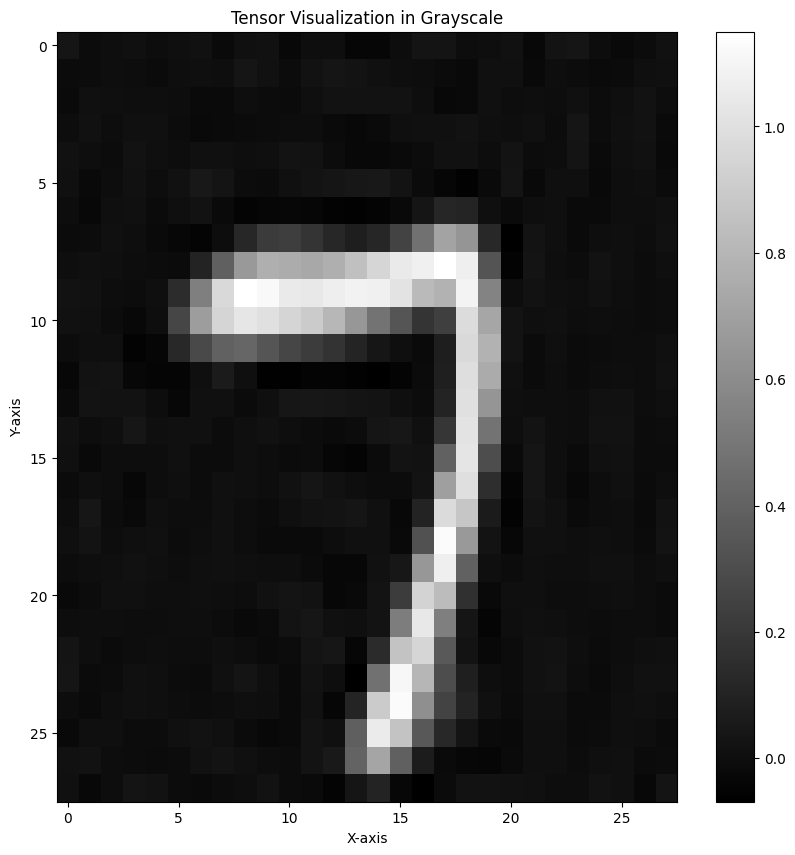

In [4]:
import torch
import matplotlib.pyplot as plt

tensor = image.squeeze(0)

# Plotting the tensor as a heatmap in grayscale
plt.figure(figsize=(10, 10))
plt.imshow(tensor, cmap='gray', aspect='auto')
plt.colorbar()
plt.title('Tensor Visualization in Grayscale')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [5]:
def get_batch(split: str):
    # get batch from dataloader
    pass

In [11]:
from collections import OrderedDict
from data.DWSNets_dataset import DWSNetsDataset, LayerOneHotTransform, FlattenTransform, BiasFlagTransform


class AutoencoderTransform(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bias = BiasFlagTransform()
    self.flatten = FlattenTransform()
    self.layer_one_hot = LayerOneHotTransform()

  def forward(self, x, y):
    bias, _ = self.bias(x, y)
    layer, _ = self.layer_one_hot(x, y)    
    x, _ = self.flatten(x, y)
    return torch.hstack((x, layer, bias)), y

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

dataset = DWSNetsDataset(data_root)
flattened_dataset = DWSNetsDataset(data_root, transform=FlattenTransform())

In [12]:
dataset[0]

(OrderedDict([('seq.0.weight',
               tensor([[-4.0755e-03,  3.0275e-02],
                       [ 3.7985e-02,  3.5304e-02],
                       [-6.5506e-02,  5.7733e-02],
                       [ 1.7344e-02, -1.8718e-02],
                       [ 3.0639e-02, -1.8703e-02],
                       [ 5.9275e-02, -5.5776e-03],
                       [-1.1590e-01,  1.9634e-02],
                       [ 2.6851e-02, -2.4524e-02],
                       [ 6.5062e-03,  1.1068e-01],
                       [-9.7189e-02,  1.0473e-01],
                       [ 6.1123e-02,  1.6021e-02],
                       [-4.6886e-02, -3.9856e-02],
                       [-7.6424e-02, -6.5537e-03],
                       [ 3.6053e-02,  6.2836e-04],
                       [ 5.1460e-02, -3.5410e-02],
                       [ 1.5411e-02, -3.3180e-03],
                       [ 2.2220e-01,  9.5588e-02],
                       [-2.1557e-02,  2.9739e-02],
                       [-1.1905e-02,  3.7337e-02],


In [13]:
flattened_dataset[0]

(tensor([[-0.0041],
         [ 0.0303],
         [ 0.0380],
         ...,
         [-0.1311],
         [ 0.1318],
         [-0.1846]]),
 1)

In [15]:
def backtransform_weights(flattened_weights, original_weights_dict):
    reconstructed_dict = OrderedDict()
    start = 0
    for key, tensor in original_weights_dict.items():
        # Get the number of elements in the tensor
        num_elements = tensor.numel()
        # Get the slice of the flattened weights corresponding to this tensor
        flattened_slice = flattened_weights[start:start + num_elements]
        # Reshape the slice to the shape of the original tensor
        reconstructed_tensor = flattened_slice.view(tensor.shape)
        # Add to the reconstructed dictionary
        reconstructed_dict[key] = reconstructed_tensor
        # Update the start index for the next slice
        start += num_elements
    
    return reconstructed_dict

dataset_ele = dataset[0][0]
dataset_ele_flattened= flattened_dataset[0][0]

reconstructed_dict = backtransform_weights(dataset_ele_flattened, dataset_ele)

In [16]:
reconstructed_dict

OrderedDict([('seq.0.weight',
              tensor([[-4.0755e-03,  3.0275e-02],
                      [ 3.7985e-02,  3.5304e-02],
                      [-6.5506e-02,  5.7733e-02],
                      [ 1.7344e-02, -1.8718e-02],
                      [ 3.0639e-02, -1.8703e-02],
                      [ 5.9275e-02, -5.5776e-03],
                      [-1.1590e-01,  1.9634e-02],
                      [ 2.6851e-02, -2.4524e-02],
                      [ 6.5062e-03,  1.1068e-01],
                      [-9.7189e-02,  1.0473e-01],
                      [ 6.1123e-02,  1.6021e-02],
                      [-4.6886e-02, -3.9856e-02],
                      [-7.6424e-02, -6.5537e-03],
                      [ 3.6053e-02,  6.2836e-04],
                      [ 5.1460e-02, -3.5410e-02],
                      [ 1.5411e-02, -3.3180e-03],
                      [ 2.2220e-01,  9.5588e-02],
                      [-2.1557e-02,  2.9739e-02],
                      [-1.1905e-02,  3.7337e-02],
                    

In [17]:
dataset_ele

OrderedDict([('seq.0.weight',
              tensor([[-4.0755e-03,  3.0275e-02],
                      [ 3.7985e-02,  3.5304e-02],
                      [-6.5506e-02,  5.7733e-02],
                      [ 1.7344e-02, -1.8718e-02],
                      [ 3.0639e-02, -1.8703e-02],
                      [ 5.9275e-02, -5.5776e-03],
                      [-1.1590e-01,  1.9634e-02],
                      [ 2.6851e-02, -2.4524e-02],
                      [ 6.5062e-03,  1.1068e-01],
                      [-9.7189e-02,  1.0473e-01],
                      [ 6.1123e-02,  1.6021e-02],
                      [-4.6886e-02, -3.9856e-02],
                      [-7.6424e-02, -6.5537e-03],
                      [ 3.6053e-02,  6.2836e-04],
                      [ 5.1460e-02, -3.5410e-02],
                      [ 1.5411e-02, -3.3180e-03],
                      [ 2.2220e-01,  9.5588e-02],
                      [-2.1557e-02,  2.9739e-02],
                      [-1.1905e-02,  3.7337e-02],
                    

In [23]:
loss = torch.nn.CrossEntropyLoss()
loss(torch.Tensor([0, 0, 1]), torch.Tensor([1, 0, 0]))

tensor(1.5514)

In [ ]:
import 